# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [73]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [74]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = "pk.eyJ1Ijoic3Viam9pbjUwIiwiYSI6ImNrOWRpaTJodDA0MnUza2xnNDR2YWoxdHUifQ.qt904TrF0PvekgvDUpDOqA"
#mapbox_token = os.getenv("MAPBOX")

# Import Data

In [75]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [76]:
# Define Panel Visualization Functions
def housing_units_per_year():
    df_housing_units = sfo_data["housing_units"].groupby(sfo_data.index).mean()
    
    fig_housing_units = plt.figure()
    plot_housing_units = df_housing_units.plot.bar()
    plot_housing_units.set_xlabel("Year")
    plot_housing_units.set_ylabel("Housing Units")
    plot_housing_units.set_title("Housing Units in San Francisco from 2010 to 2016", fontsize=12, fontweight="bold")

    housing_units_std = df_housing_units.std()
    min_unit_housing = min(df_housing_units)
    max_unit_housing = max(df_housing_units)

    plot_housing_units.set_ylim(min_unit_housing - housing_units_std, max_unit_housing + housing_units_std)
    plt.close(fig_housing_units)
    
    return pn.pane.Matplotlib(fig_housing_units, tight=True)


In [77]:
def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    df_avg_costs = (sfo_data[["sale_price_sqr_foot", "gross_rent"]].groupby('year').mean())
    
    fig_avg_gross_rent = plt.figure()
    plot_avg_gross_rent = df_avg_costs["gross_rent"].plot()
    plot_avg_gross_rent.set_xlabel("Year")
    plot_avg_gross_rent.set_ylabel("Gross Rent")
    plot_avg_gross_rent.set_title("Average Gross Rent in San Francisco", fontsize=14, fontweight="bold")
    plt.close(fig_avg_gross_rent)
    return pn.pane.Matplotlib(fig_avg_gross_rent, tight=True) 

In [78]:
def average_sales_price():
    """Average Sales Price Per Year."""
    df_avg_costs = (sfo_data[["sale_price_sqr_foot", "gross_rent"]].groupby('year').mean())    
    
    fig_avg_sale_price = plt.figure()
    plot_avg_sale_price = df_avg_costs["sale_price_sqr_foot"].plot()
    plot_avg_sale_price.set_xlabel("Year")
    plot_avg_sale_price.set_ylabel("Avg. Sale Price")
    plot_avg_sale_price.set_title("Average Sale Price per Square Foot", fontsize=14, fontweight="bold")
    plt.close(fig_avg_sale_price)
    return pn.pane.Matplotlib(fig_avg_sale_price, tight=True)  
    

In [79]:
def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    df_costs = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    df_costs.reset_index(inplace=True)
    df_costs.rename(columns={"level_0": "year"}, inplace=True)
    
    sale_price_curve = df_costs.hvplot.line("year", "sale_price_sqr_foot", xlabel="Year", ylabel="Avg. Sale Price per Square Foot", groupby="neighborhood",)
    return sale_price_curve

In [80]:
def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    expensive_neighborhoods = expensive_neighborhoods.sort_values(by="sale_price_sqr_foot", ascending=False).head()
    expensive_neighborhoods = expensive_neighborhoods.reset_index()

    expensive_10_neighborhoods = expensive_neighborhoods.hvplot.bar(
        "neighborhood", 
        "sale_price_sqr_foot", 
        title="Top 10 Expensive Neighborhoods in SFO",
        xlabel="Neighborhood",
        ylabel="Avg. Sale Price per Square Foot",
        rot=90,
    )
    return expensive_10_neighborhoods

In [81]:
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    expensive_neighborhoods = expensive_neighborhoods.sort_values( by="sale_price_sqr_foot", ascending=False).head(10)
    expensive_neighborhoods = expensive_neighborhoods.reset_index()
    
    expensive_plot = px.parallel_coordinates(
        expensive_neighborhoods,
        color="sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno,
    )
    return expensive_plot   

In [86]:
def parallel_categories():
    """Parallel Categories Plot."""
    expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    expensive_neighborhoods = expensive_neighborhoods.sort_values( by="sale_price_sqr_foot", ascending=False).head(10)
    expensive_neighborhoods = expensive_neighborhoods.reset_index()
    
    expensive_plot = px.parallel_categories(
        expensive_neighborhoods,
        color="sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno,
    )
    return expensive_plot

In [83]:
def neighborhood_map():
    """Neighborhood Map"""
    
    df_all_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    df_all_neighborhoods.reset_index(inplace=True)
    df_all_neighborhoods.rename(columns={"neighborhood": "Neighborhood"}, inplace=True)

    df_all_neighborhoods = pd.merge(df_neighborhood_locations, df_all_neighborhoods, on="Neighborhood")

    px.set_mapbox_access_token(mapbox_token)
    map = px.scatter_mapbox(
        df_all_neighborhoods,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        hover_name="Neighborhood",
        title="Averange Sale Price Per Square Foot and Gross Rent in San Francisco",
    )
    plotly_panel = pn.pane.Plotly(map)
    plotly_panel._updates = True
    return plotly_panel

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [84]:
# YOUR CODE HERE!
housing_units = pn.Column (housing_units_per_year())
gross_rent = pn.Column(average_gross_rent())
sales_price = pn.Column(average_sales_price())
parallel = pn.Column(parallel_coordinates())
avg_nei = pn.Column(average_price_by_neighborhood())
most_expbar = pn.Column(top_most_expensive_neighborhoods())



panel = pn.Tabs(
    ("Housing Units", housing_units), 
    ("Avg. Gross Rent",gross_rent) , 
    ("Avg. Sales Price",sales_price) ,
    ("Parallel Coordinates",parallel),
    ("Avg. Price by Neighborhood",avg_nei),
    ("10 Most Expensive Neighborhoods",most_expbar)
)

## Serve the Panel Dashboard

Tabs
    [0] Column
        [0] Matplotlib(Figure, tight=True)
    [1] Column
        [0] Matplotlib(Figure, tight=True)
    [2] Column
        [0] Matplotlib(Figure, tight=True)
    [3] Column
        [0] Plotly(Figure)
    [4] Column
        [0] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [5] Column
        [0] HoloViews(Bars)
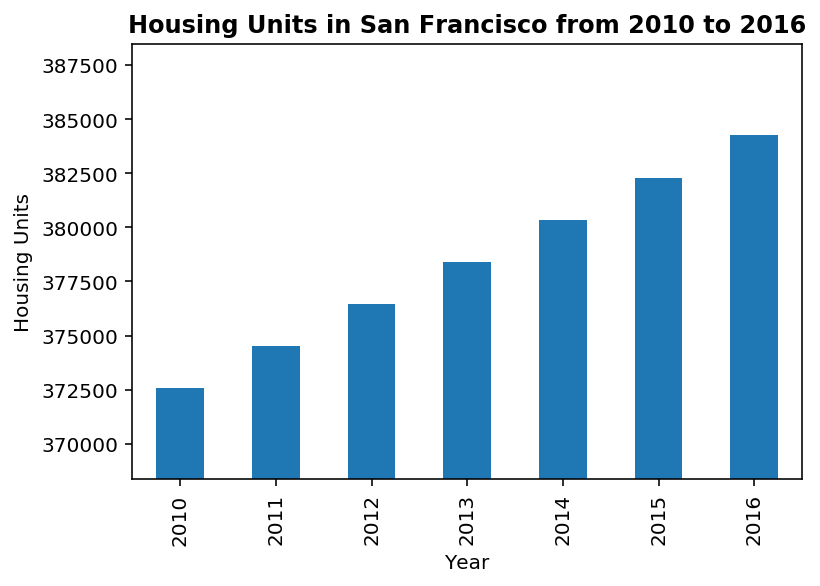
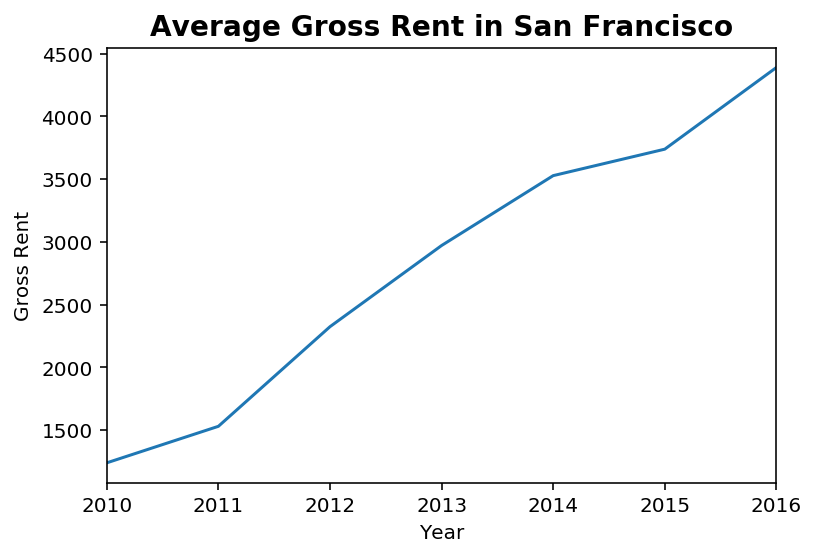
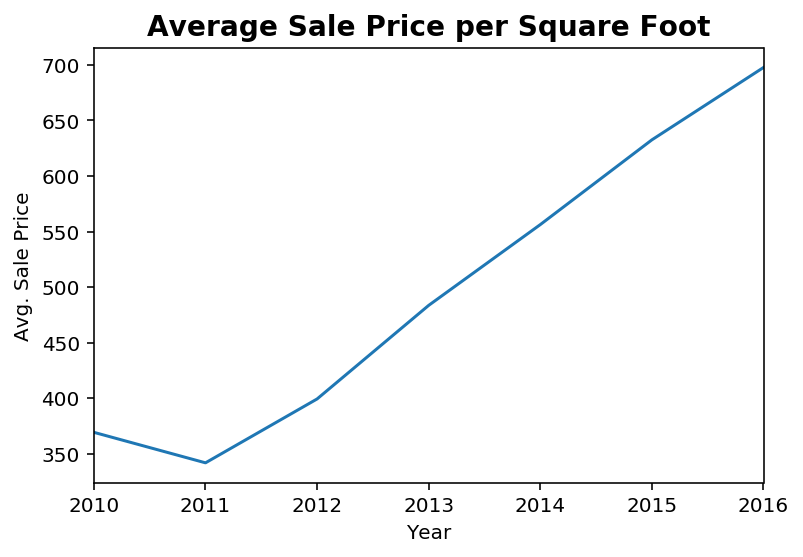

In [85]:
panel.servable()